In [1]:
from glob import glob
import warnings

import altair as alt
from altair import datum
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelBinarizer

from credit_card_churn_clf.data.data_funcs import read_credit_card_churn_split
from credit_card_churn_clf.models.modeling_funcs import predict_on_test_set

In [2]:
warnings.filterwarnings("ignore")

In [3]:
alt.data_transformers.enable("json")
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [4]:
X_train, y_train = read_credit_card_churn_split(
    "../data/splits/credit_card_churn_train_test.pkl", 
    train_or_test="train", 
    split_y=True
)

X_test, y_test = read_credit_card_churn_split(
    "../data/splits/credit_card_churn_train_test.pkl", 
    train_or_test="test", 
    split_y=True
)

## Melhores Modelos

In [5]:
models = []

for m in glob("../models/*.pkl"):
    model = joblib.load(m)
    print("Estimator: ", model.estimator.named_steps["clf"].__class__.__name__)
    print("AUC do Melhor Estimador: ", model.best_score_)
    models += [model]

Estimator:  DecisionTreeClassifier
AUC do Melhor Estimador:  0.957075009516891
Estimator:  GradientBoostingClassifier
AUC do Melhor Estimador:  0.993545176141445
Estimator:  LogisticRegression
AUC do Melhor Estimador:  0.937262933828932
Estimator:  RandomForestClassifier
AUC do Melhor Estimador:  0.9833461322357463


## Precision Recall Curve

In [6]:
pr_rec_dfs = []

for m in glob("../models/*.pkl"):
    model = joblib.load(m)
    model_name = model.estimator.named_steps["clf"].__class__.__name__
    y_preds = cross_val_predict(model.best_estimator_, X_train, y_train, cv = 5, method = "predict_proba")
    precision, recall, thresholds = precision_recall_curve(y_true=y_train, probas_pred=y_preds[:, 1])        
    data_ = pd.DataFrame({"model": [model_name]*len(thresholds), "recall": recall[:-1], "precision": precision[:-1], "thresholds": thresholds})
    pr_rec_dfs.append(data_)
    print(model_name)
    
pr_rec_df = pd.concat(pr_rec_dfs)

DecisionTreeClassifier
GradientBoostingClassifier
LogisticRegression
RandomForestClassifier


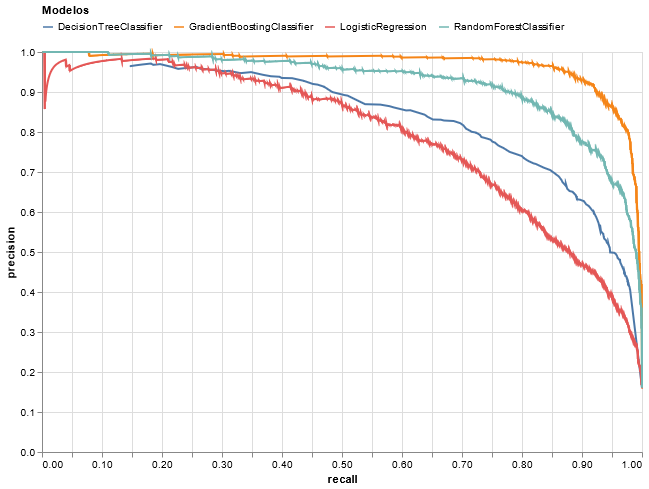

In [7]:
pr_rec_plot = alt.Chart(pr_rec_df).mark_line().encode(
    x="recall:Q",
    y="precision:Q",
    color=alt.Color("model:N", legend=alt.Legend(orient="top", title="Modelos")),
    tooltip=["model:N", "recall:Q", "precision:Q", "thresholds:Q"]
).properties(height=400, width=600)

pr_rec_plot

## ROC Curve

In [8]:
roc_dfs = []

for m in glob("../models/*.pkl"):
    model = joblib.load(m)
    model_name = model.estimator.named_steps["clf"].__class__.__name__
    y_preds = cross_val_predict(model.best_estimator_, X_train, y_train, cv = 5, method = "predict_proba")
    fpr, tpr, thresholds = roc_curve(y_true=y_train, y_score=y_preds[:, 1])
    auc_ = model.best_score_
    data_ = pd.DataFrame({"model": [model_name]*len(fpr), "fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": [auc_]*len(fpr)})
    roc_dfs.append(data_)
    print(model_name)
    
roc_curves_df = pd.concat(roc_dfs)

DecisionTreeClassifier
GradientBoostingClassifier
LogisticRegression
RandomForestClassifier


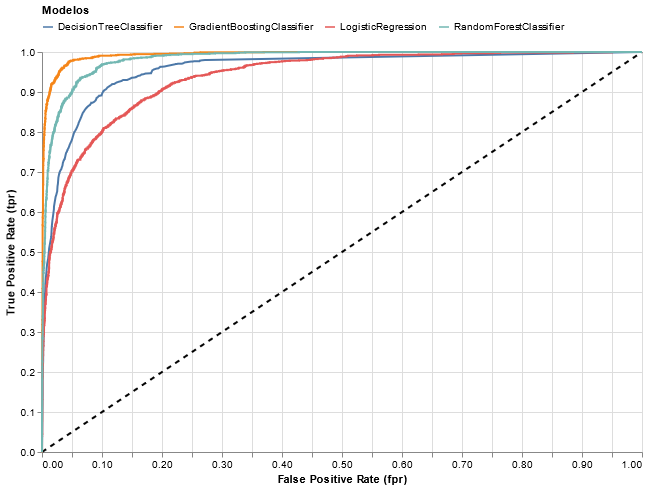

In [9]:
line = pd.DataFrame({"fpr": [0, 1], "tpr": [0, 1]})

base_plot = alt.Chart(line).mark_line(color="black", strokeDash=[5, 5]).encode(
    x=alt.X("fpr", title="False Positive Rate (fpr)"),
    y=alt.Y("tpr", title="True Positive Rate (tpr)")
)

roc_plot = alt.Chart(roc_curves_df).mark_line().encode(
    x="fpr:Q",
    y="tpr:Q",
    color=alt.Color("model:N", legend=alt.Legend(orient="top", title="Modelos")),
    tooltip=["model:N", "fpr:Q", "tpr:Q", "thresholds:Q", "auc:Q"]
)

(base_plot + roc_plot).properties(height=400, width=600)

## Predição no Conjunto de Teste

O melhor modelo entre os avaliados é o Gradient Boosting, oferecendo um ROC AUC muito próximo ao perfeito no conjunto de validação. A curva de Precisão x Recall também mostra que o Gradient Boosting retorna resultados excelentes para as duas métricas. A um threshold padrão de 50%, o Gradient Boosting oferece uma Precisão de 94% e um Recall de 89%. Modificar o threshold pra 22% traz 91% tanto para as duas métricas.

Sendo esse esse o modelo escolhido, podemos verificar sua performance no conjunto de teste.

In [10]:
gr_clf = joblib.load("../models/GradientBoostingClassifier.pkl").best_estimator_

y_scores = gr_clf.predict_proba(X_test)[:, 1] >= 0.22
print("Roc Auc de Teste: ", roc_auc_score(y_test, y_scores))
print("Precisão: ", precision_score(y_test, y_scores))
print("Recall: ", recall_score(y_test, y_scores))

Roc Auc de Teste:  0.9420049210454792
Precisão:  0.891566265060241
Recall:  0.9051987767584098
